# Real World P-Dispersion Problem

*Authors:* [Erin Olson](https://github.com/erinrolson), [Germano Barcelos](https://github.com/gegen07), [James Gaboardi](https://github.com/jGaboardi), [Levi J. Wolf](https://github.com/ljwolf), [Qunshan Zhao](https://github.com/qszhao)

In [1]:
%config InlineBackend.figure_format = "retina"
%load_ext watermark
%watermark

Last updated: 2022-10-18T10:50:38.711094-04:00

Python implementation: CPython
Python version       : 3.10.6
IPython version      : 8.5.0

Compiler    : Clang 13.0.1 
OS          : Darwin
Release     : 21.6.0
Machine     : x86_64
Processor   : i386
CPU cores   : 8
Architecture: 64bit



In [2]:
import geopandas
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import matplotlib.lines as mlines
import matplotlib_scalebar
from matplotlib_scalebar.scalebar import ScaleBar
import numpy
import pandas
import pulp
from shapely.geometry import Point
import time

%watermark -w
%watermark -iv

Watermark: 2.3.1

geopandas          : 0.11.1
matplotlib         : 3.6.1
json               : 2.0.9
pulp               : 2.6.0
numpy              : 1.23.3
pandas             : 1.5.0
matplotlib_scalebar: 0.8.1



The problem is composed by 2 datafiles
- facility_points represents the stores that are candidate facility sites
- tract is the polygon of census tract 205.

Please note that all other 'Real World Facility Location' demonstration notebooks utilize [this file](https://github.com/huanfachen/Open_source_location_cover_models/blob/master/Data/San_Francisco_store/SF_network_distance_candidateStore_16_censusTract_205_new.csv) which contains facility-client network distances that were calculated using the ArcGIS Network Analyst Extension. This notebook, solving for P-Dispersion, *does not* use this file or any network distances and instead relies on euclidean distance for solving the model.

All datasets are available online in this [repository](https://github.com/huanfachen/Open_source_location_cover_models/tree/master/Data/San_Francisco_store)

In [3]:
DIRPATH = "../spopt/tests/data/"

facility_points = pandas.read_csv(DIRPATH + "SF_store_site_16_longlat.csv", index_col=0)
study_area = geopandas.read_file(DIRPATH + "ServiceAreas_4.shp").dissolve()

Display facility_points dataframe

In [4]:
display(facility_points)

,OBJECTID,NAME,long,lat
1,1,Store_1,-122.510018,37.772364
2,2,Store_2,-122.488873,37.753764
3,3,Store_3,-122.464927,37.774727
4,4,Store_4,-122.473945,37.743164
5,5,Store_5,-122.449291,37.731545
6,6,Store_6,-122.491745,37.649309
7,7,Store_7,-122.483182,37.701109
8,8,Store_11,-122.433782,37.655364
9,9,Store_12,-122.438982,37.719236
10,10,Store_13,-122.440218,37.745382


Plot tract

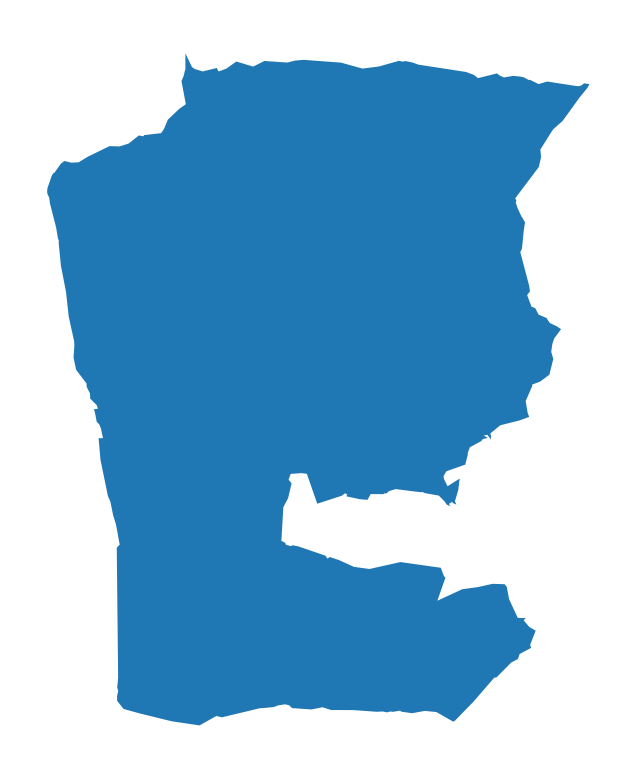

In [5]:
base = study_area.plot()
base.axis("off");

Create a geodataframe of the candidate facility sites.

In [6]:
n_fac_pnts = facility_points.shape[0]
facility_points_gdf = geopandas.GeoDataFrame(
    facility_points,
    geometry=geopandas.points_from_xy(facility_points.long, facility_points.lat),
)
facility_points_gdf

,OBJECTID,NAME,long,lat,geometry
1,1,Store_1,-122.510018,37.772364,POINT (-122.51002 37.77236)
2,2,Store_2,-122.488873,37.753764,POINT (-122.48887 37.75376)
3,3,Store_3,-122.464927,37.774727,POINT (-122.46493 37.77473)
4,4,Store_4,-122.473945,37.743164,POINT (-122.47395 37.74316)
5,5,Store_5,-122.449291,37.731545,POINT (-122.44929 37.73155)
6,6,Store_6,-122.491745,37.649309,POINT (-122.49175 37.64931)
7,7,Store_7,-122.483182,37.701109,POINT (-122.48318 37.70111)
8,8,Store_11,-122.433782,37.655364,POINT (-122.43378 37.65536)
9,9,Store_12,-122.438982,37.719236,POINT (-122.43898 37.71924)
10,10,Store_13,-122.440218,37.745382,POINT (-122.44022 37.74538)


The below method is used to plot the results of the solved P-Dispersion problems.

In [7]:
dv_colors = [
    "darkslategray",
    "lightskyblue",
    "limegreen",
    "darkgoldenrod",
    "peachpuff",
    "coral",
    "mediumvioletred",
    "blueviolet",
    "fuchsia",
    "thistle",
    "lavender",
    "saddlebrown",
]


def plot_results(model, facility_points, title):
    def define_edgecolor(idf):
        if "predefined_loc" in idf.columns:
            if idf.predefined_loc.iloc[0]:
                return "red"

        return "k"

    def define_label(idf):
        if "predefined_loc" in idf.columns:
            if idf.predefined_loc.iloc[0]:
                return " (predefined)"

        return ""

    fac_sites = []

    for i in range(len(facility_points)):
        if model.fac_vars[i].varValue == 1:
            fac_sites.append(i)

    sited_facilities = range(len(fac_sites))

    fig, ax = plt.subplots(figsize=(10, 15))
    legend_elements = []

    facility_points.plot(ax=ax, color="brown", marker="*", markersize=80, zorder=2)
    legend_elements.append(
        mlines.Line2D(
            [],
            [],
            color="brown",
            marker="*",
            linewidth=0,
            label=f"facility sites ($n$={n_fac_pnts})",
        )
    )

    study_area.plot(ax=ax, alpha=0.5, fc="tan", ec="k", zorder=1)
    _patch = Patch(alpha=0.5, fc="tan", ec="k", label="Dissolved Service Areas")
    legend_elements.append(_patch)

    for i in sited_facilities:
        facility_points.iloc[[fac_sites[i]]].plot(
            ax=ax,
            marker="*",
            markersize=200 * 3.0,
            alpha=0.8,
            zorder=4,
            edgecolor=define_edgecolor(facility_points.iloc[[fac_sites[i]]]),
            facecolor=dv_colors[i],
        )

    for i in sited_facilities:

        fac = fac_sites[i]
        fname = facility_points.iloc[[fac]]["NAME"]
        fname = f"{fname.squeeze().replace('_', ' ')}"

        legend_elements.append(
            mlines.Line2D(
                [],
                [],
                color=dv_colors[i],
                marker="*",
                ms=20 / 2,
                markeredgecolor=define_edgecolor(facility_points.iloc[[fac_sites[i]]]),
                linewidth=0,
                alpha=0.8,
                label=f"{fname}" + define_label(facility_points.iloc[[fac_sites[i]]]),
            )
        )

    plt.title(title, fontweight="bold")
    plt.legend(handles=legend_elements, loc="upper left", bbox_to_anchor=(1.05, 1))

    x, y, xyc, arrow_length, c = 0.925, 0.15, "axes fraction", 0.1, "center"
    xy, xyt = (x, y), (x, y - arrow_length)
    ap = dict(facecolor="black", width=5, headwidth=10)
    kws = dict(arrowprops=ap, ha=c, va=c, fontsize=20)
    plt.annotate("N", xy=xy, xycoords=xyc, xytext=xyt, **kws)

    plt.gca().add_artist(ScaleBar(1))

In [8]:
for _df in [facility_points_gdf, study_area]:
    _df.set_crs("EPSG:4326", inplace=True)
    _df.to_crs("EPSG:7131", inplace=True)

## P-Dispersion

In [9]:
from spopt.locate import PDispersion

In [10]:
# number of facilities to be sited
p = 4

start_1 = time.time()
p_dispersion = PDispersion.from_geodataframe(
    facility_points_gdf, "geometry", p, distance_metric="euclidean"
)
end_1 = time.time()

time_spent_1 = end_1 - start_1

In [11]:
start_2 = time.time()
p_dispersion = p_dispersion.solve(pulp.PULP_CBC_CMD(msg=False, warmStart=True))
end_2 = time.time()

time_spent_2 = end_2 - start_2
total_time = time_spent_1 + time_spent_2

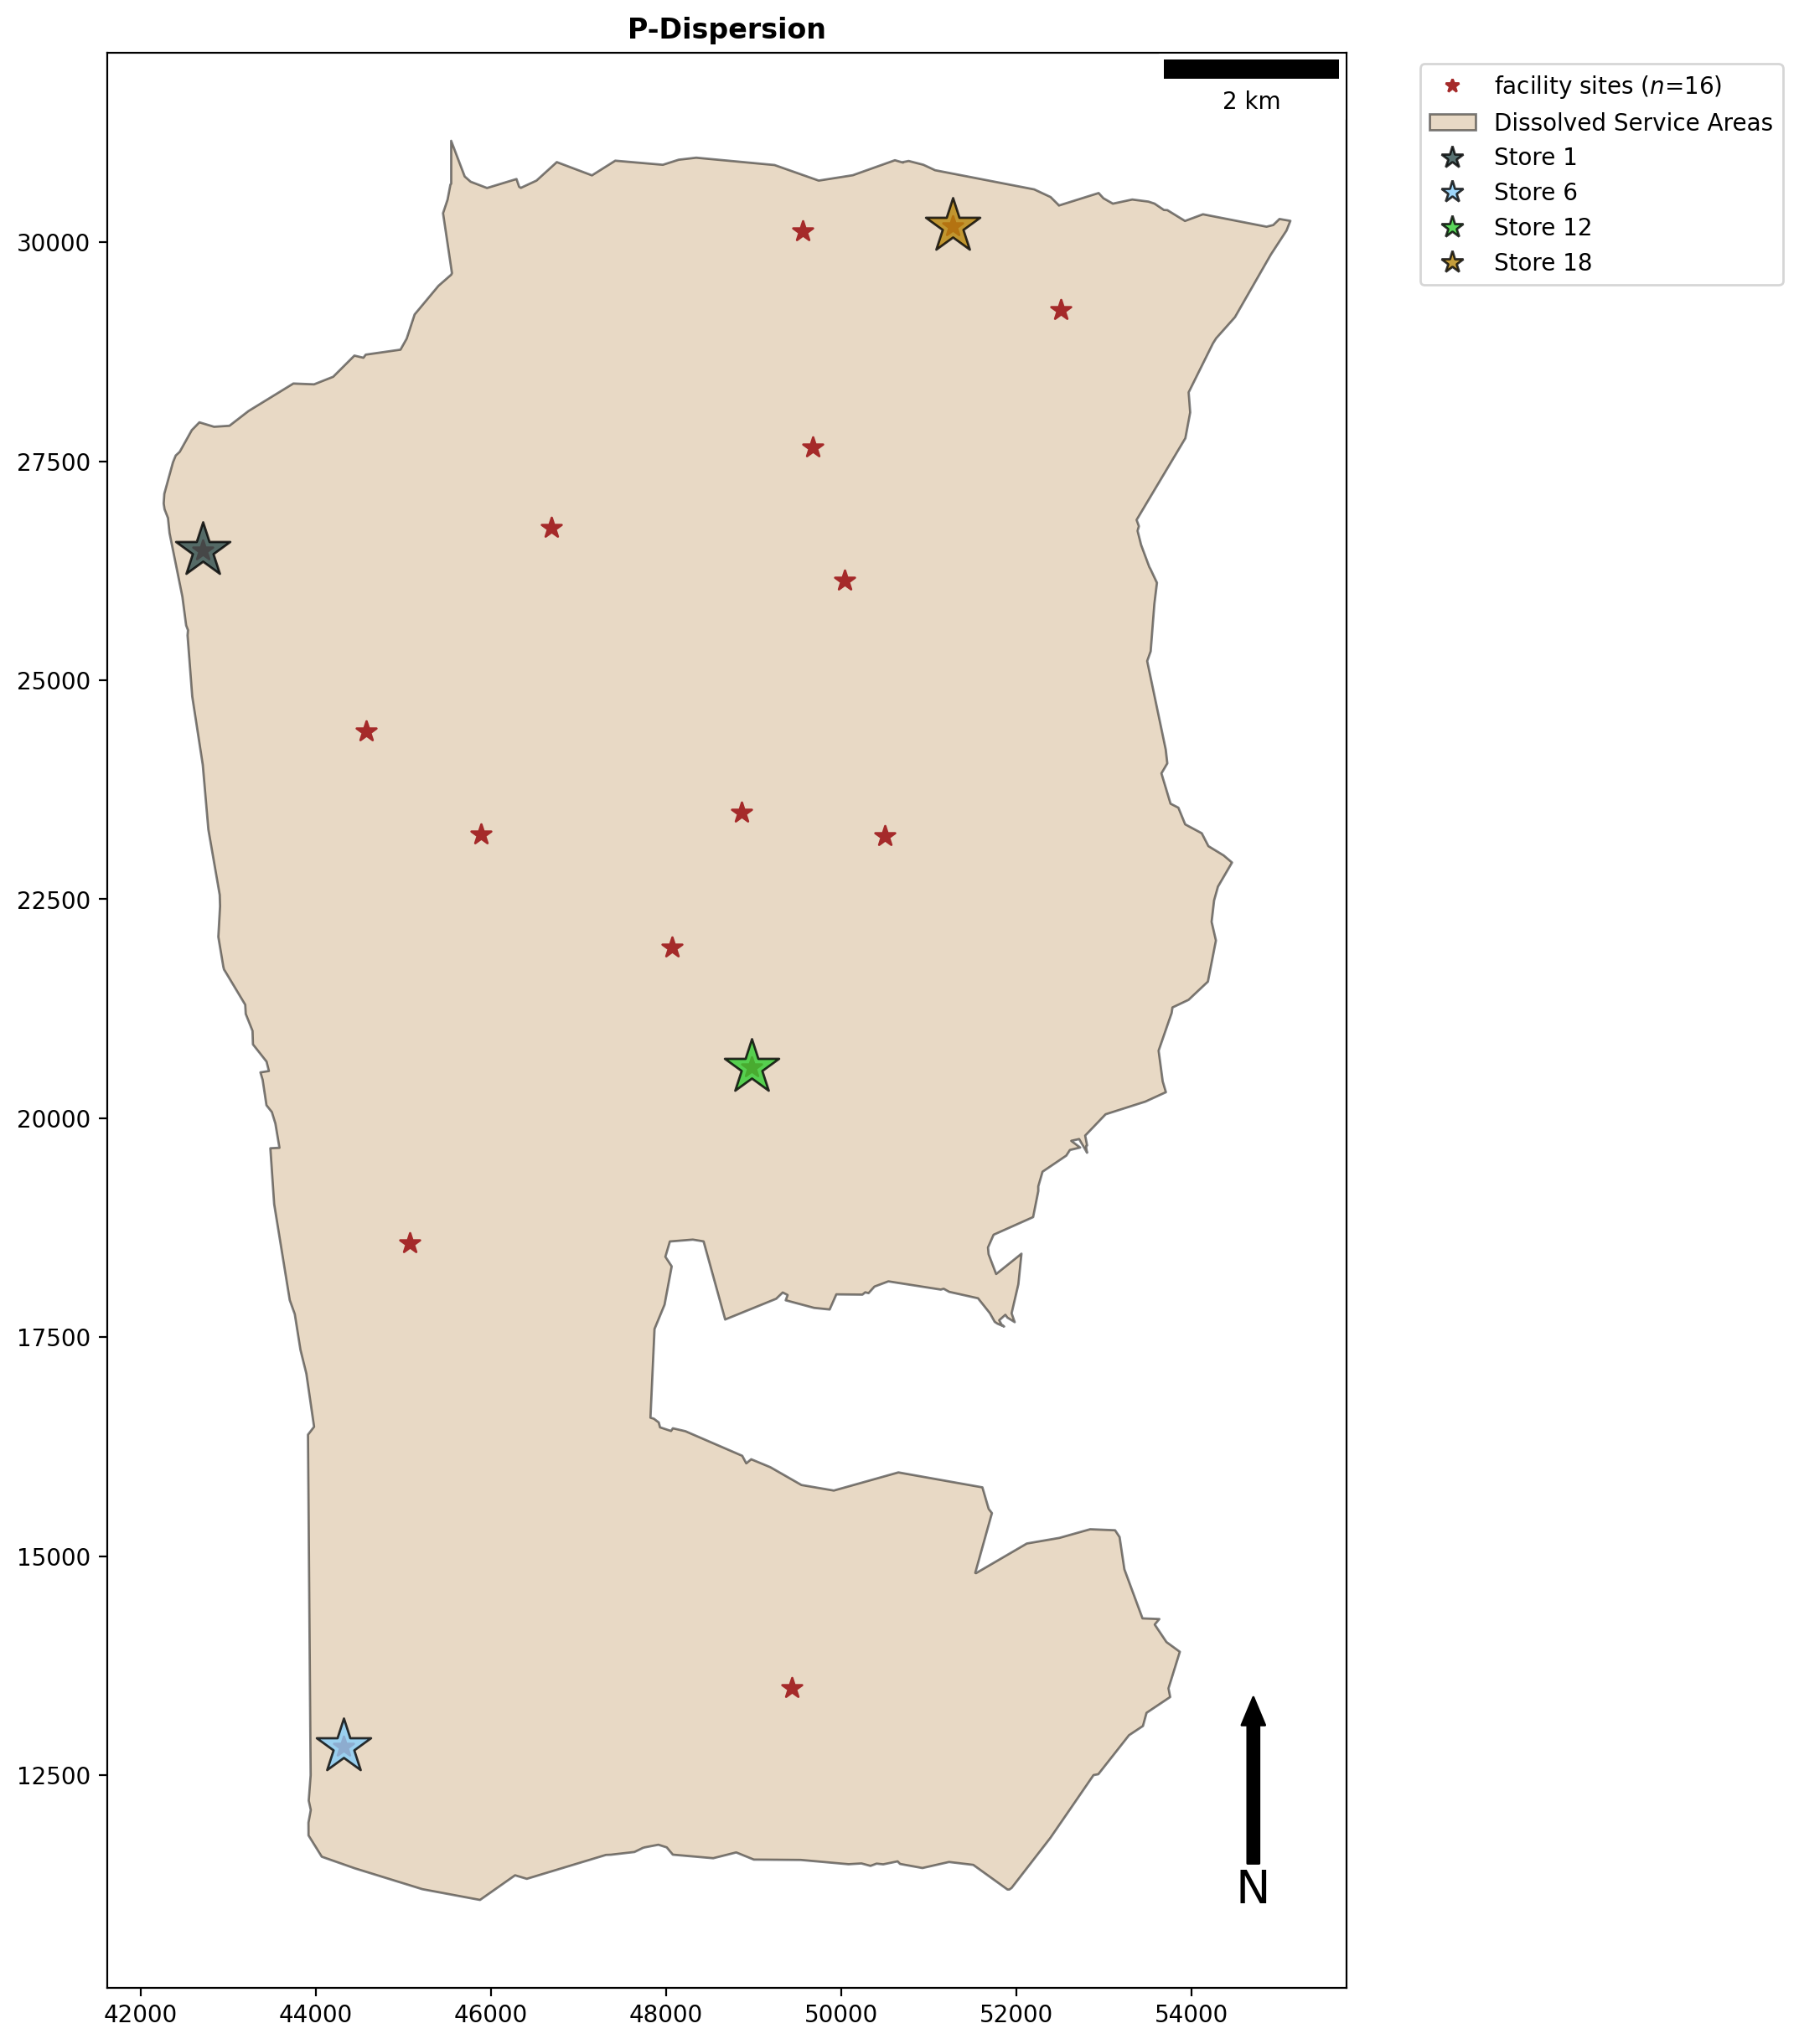

In [12]:
plot_results(p_dispersion, facility_points_gdf, "P-Dispersion")

## PDispersion San Francisco Case Study Results

In [13]:
print(
    f"San Francisco Dataset\n\tCandidate Facilities: {n_fac_pnts}\n"
    f"\tNumber of Facilities Solved for: {p}\n\tComputation Time: {total_time}"
)

San Francisco Dataset
	Candidate Facilities: 16
	Number of Facilities Solved for: 4
	Computation Time: 0.11865997314453125


In [14]:
facility_points_gdf["predefined_loc"] = numpy.array(
    [0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0]
)
facility_points_gdf

,OBJECTID,NAME,long,lat,geometry,predefined_loc
1,1,Store_1,-122.510018,37.772364,POINT (42712.165 26483.898),0
2,2,Store_2,-122.488873,37.753764,POINT (44574.304 24418.447),0
3,3,Store_3,-122.464927,37.774727,POINT (46684.891 26744.653),0
4,4,Store_4,-122.473945,37.743164,POINT (45889.483 23241.485),1
5,5,Store_5,-122.449291,37.731545,POINT (48062.508 21951.687),0
6,6,Store_6,-122.491745,37.649309,POINT (44315.976 12824.977),0
7,7,Store_7,-122.483182,37.701109,POINT (45073.750 18574.015),0
8,8,Store_11,-122.433782,37.655364,POINT (49431.133 13496.279),1
9,9,Store_12,-122.438982,37.719236,POINT (48971.439 20585.532),0
10,10,Store_13,-122.440218,37.745382,POINT (48862.129 23487.462),0


In [15]:
# number of facilities to be sited
p = 6

start_1 = time.time()
p_dispersion = PDispersion.from_geodataframe(
    facility_points_gdf,
    "geometry",
    p,
    predefined_facility_col="predefined_loc",
    distance_metric="euclidean",
)
end_1 = time.time()

time_spent_1 = end_1 - start_1

In [16]:
start_2 = time.time()
p_dispersion = p_dispersion.solve(pulp.PULP_CBC_CMD(msg=False, warmStart=True))
end_2 = time.time()

time_spent_2 = end_2 - start_2
total_time = time_spent_1 + time_spent_2

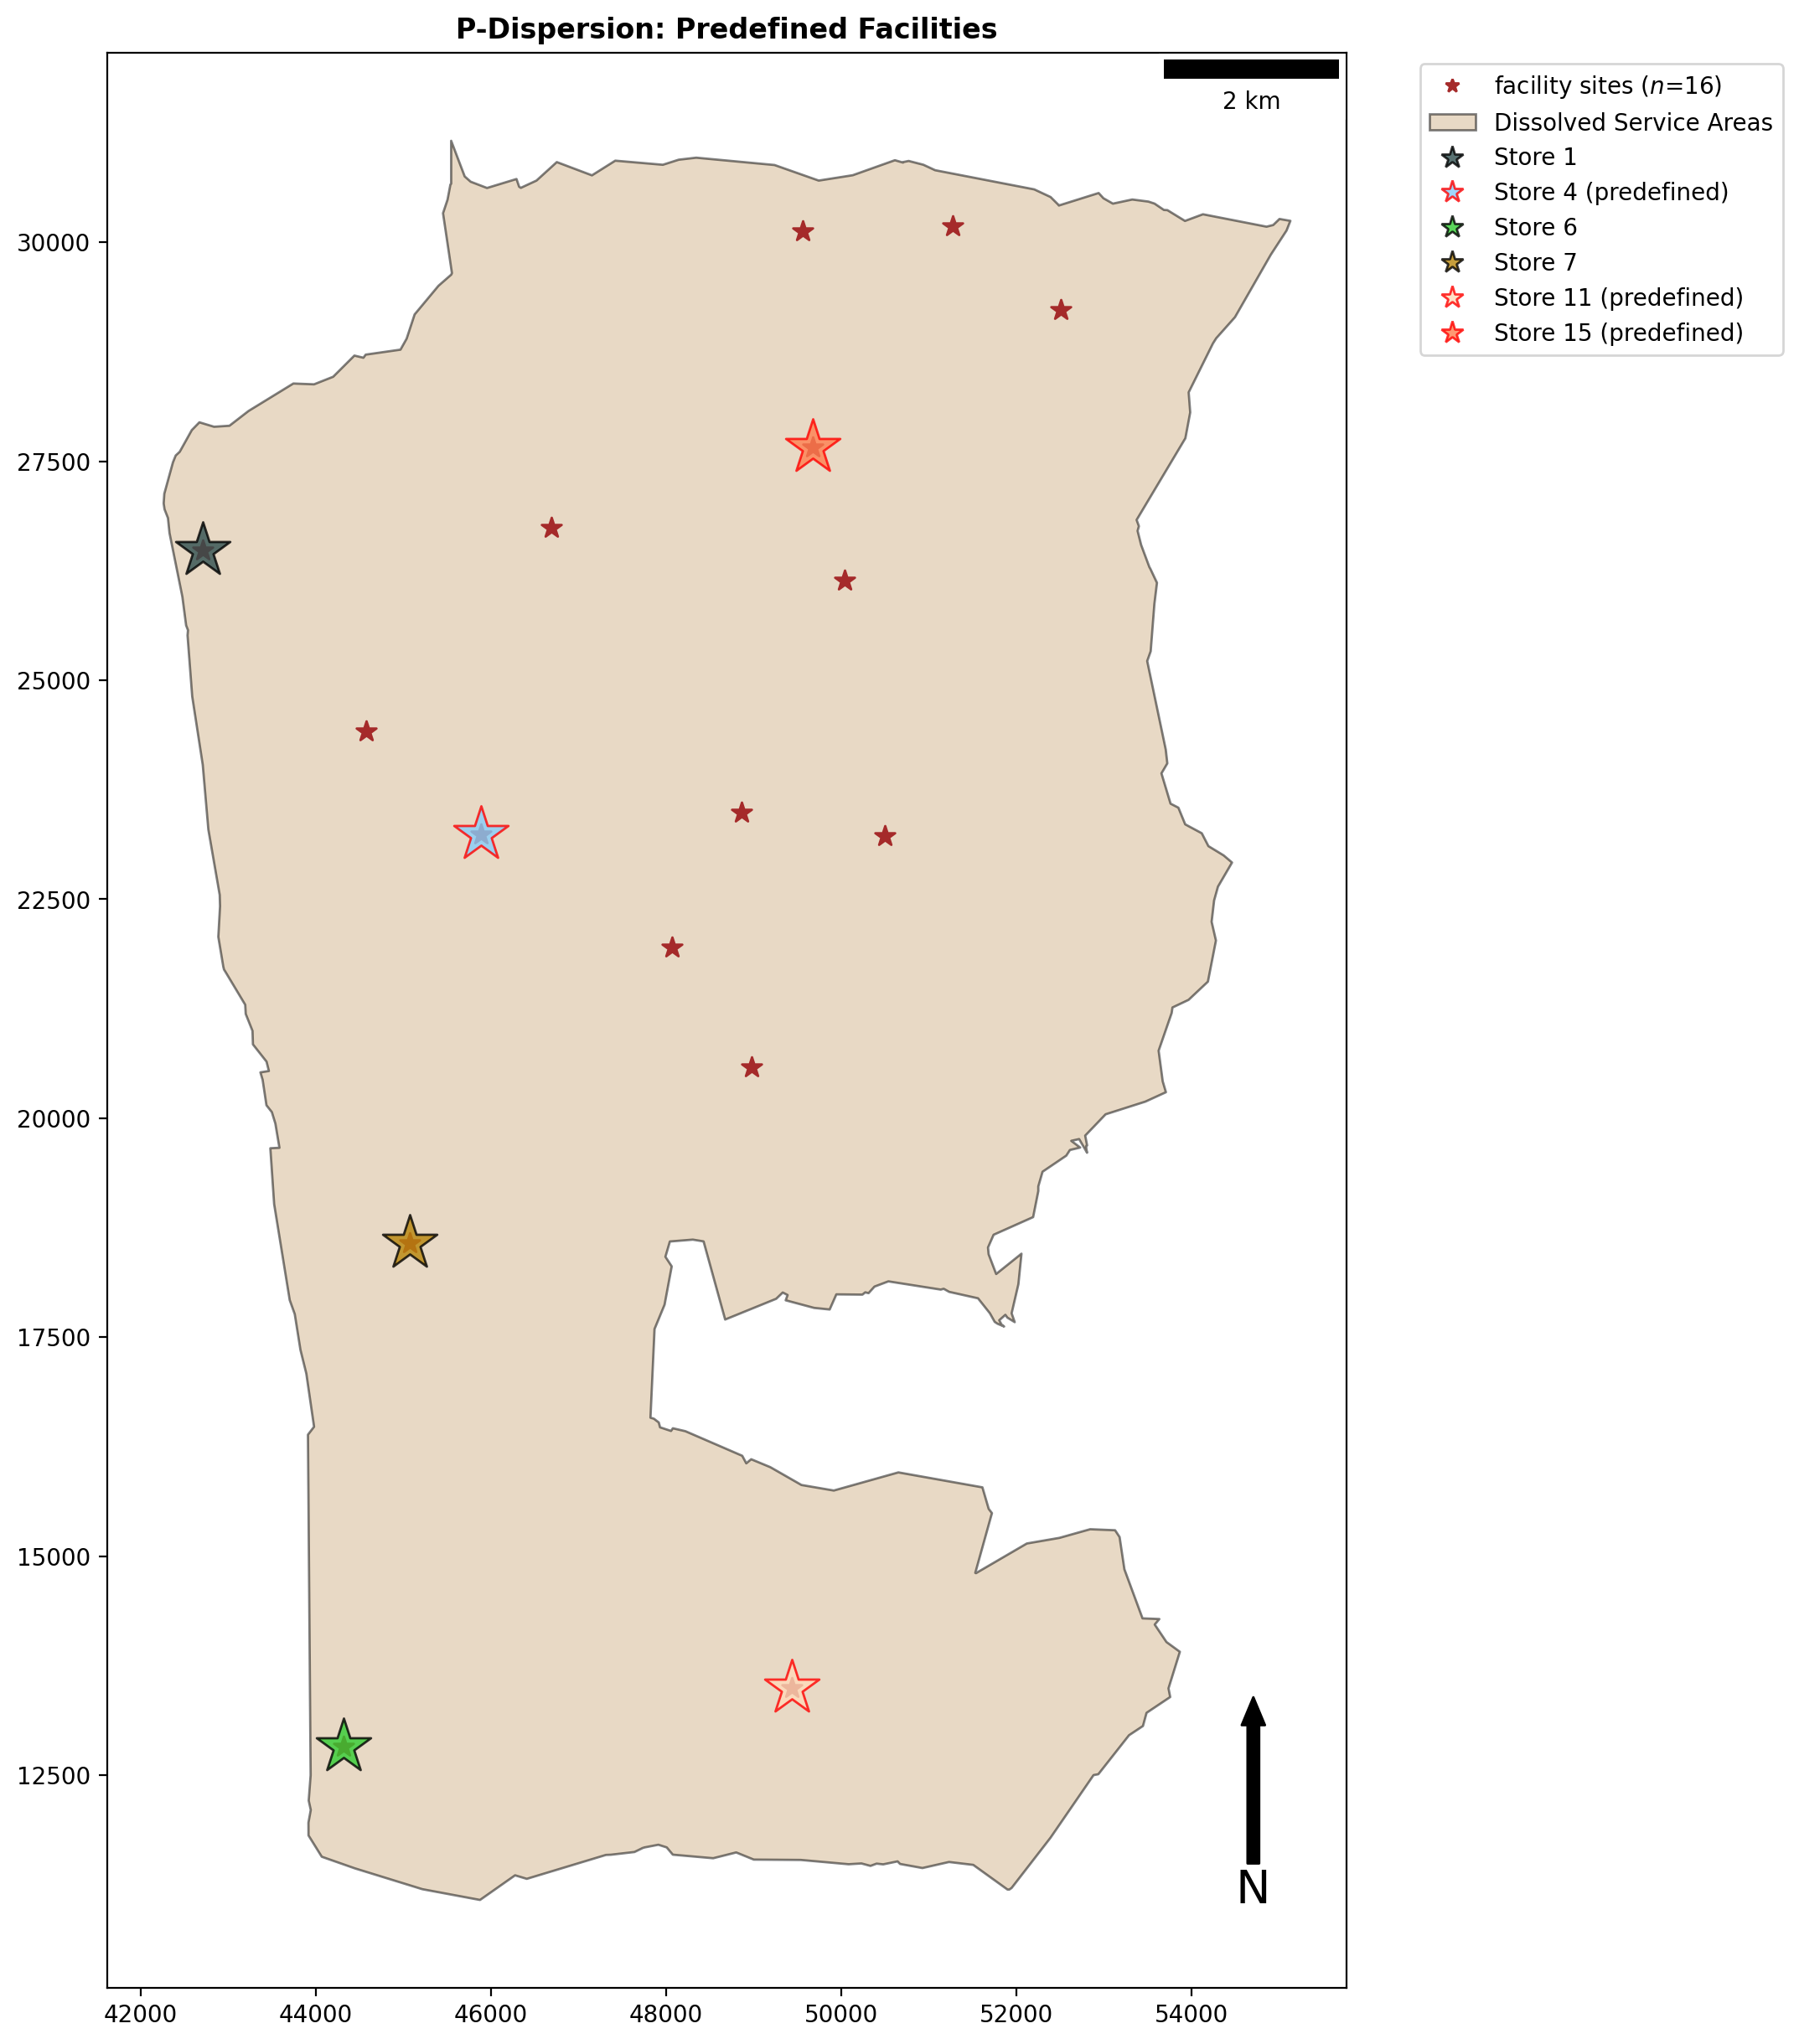

In [17]:
plot_results(p_dispersion, facility_points_gdf, "P-Dispersion: Predefined Facilities")

## PDispersion (predefined facility) San Francisco Case Study Results

In [18]:
print(
    f"San Francisco Dataset\n\tCandidate Facilities: {n_fac_pnts}\n"
    f"\tNumber of Facilities Solved for: {p}\n\tComputation Time: {total_time}"
)

San Francisco Dataset
	Candidate Facilities: 16
	Number of Facilities Solved for: 6
	Computation Time: 0.04465746879577637


----------------